In [50]:
import pandas as pd
import sys
import numpy as np
sys.path.append('../utils')
sys.path.append('..')
from pathlib import Path
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.decomposition import TruncatedSVD
from lightgbm import LGBMClassifier
import seaborn as sns
import umap
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from EDA_utils import*

In [51]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 20,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 18,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (20, 8),
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.family': 'Times New Roman',
    'legend.fontsize': 13,
    'legend.framealpha': 0.8,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

# Importing data

In [52]:
data_folder_path = Path("../Datasets/Raw/Twi_2020")
new_format_data_path = Path("../Datasets/Raw/Twibot-20-new-format")

In [53]:
neighbor_data_file = "edge.csv"
label_data_file = "label.csv"
profile_data_file = "node.part0.parquet"
# tweets_data_file = "Twi20_tweets.parquet"
split_data_file = "split.csv"

In [54]:
neighbor_df = pd.read_csv(new_format_data_path/neighbor_data_file)
label_df = pd.read_csv(new_format_data_path/label_data_file)
profile_df = pd.read_parquet(new_format_data_path/profile_data_file)
split_df = pd.read_csv(new_format_data_path/split_data_file)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
preprocessed_profile_df = pd.read_parquet("../Datasets/Processed/preprocessed_features_with_graph_embeddings.parquet")

# Modelling

In [ ]:
# Define masks to split the data into training, testing, support, and validation sets
train_mask = lambda d: d["split"] == "train"
test_mask = lambda d: d["split"] == "test"
support_mask = lambda d: d["split"] == "support"
val_mask = lambda d: d["split"] == "val"

# Define the target variable
target = "label"

In [ ]:
# Define the number of dimensions for TruncatedSVD
ndims = 10

# Feature engineering pipeline
# Create a ColumnTransformer that applies different transformations to different columns
feature_eng_pipeline = ColumnTransformer(
    [
        # Apply CountVectorizer to the 'followed_string' column
        ("vectorizer_followed", CountVectorizer(), "followed_string"),
        # Apply CountVectorizer to the 'follow_string' column
        ("vectorizer_follow", CountVectorizer(), "follow_string"),
        # Apply CountVectorizer to the 'friend_string' column
        ("vectorizer_friend", CountVectorizer(), "friend_string")
    ]
)

In [ ]:
# Add TruncatedSVD to the pipeline to reduce dimensionality to 30 components
pipeline = make_pipeline(feature_eng_pipeline, TruncatedSVD(n_components=3 * ndims))

In [ ]:
# Fit the feature engineering pipeline using the training and support data
pipeline.fit(preprocessed_profile_df[lambda d: (train_mask(d) | support_mask(d))])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('vectorizer_followed',
                                                  CountVectorizer(),
                                                  'followed_string'),
                                                 ('vectorizer_follow',
                                                  CountVectorizer(),
                                                  'follow_string'),
                                                 ('vectorizer_friend',
                                                  CountVectorizer(),
                                                  'friend_string')])),
                ('truncatedsvd', TruncatedSVD(n_components=30))])

In [ ]:
# Transform the entire DataFrame to get the graph embeddings
graph_embs = pipeline.transform(preprocessed_profile_df)

In [ ]:
# Ensure graph_embs is a dense array
if hasattr(graph_embs, "toarray"):
    graph_embs = graph_embs.toarray()

# Generate column names for the embeddings
embs_names = (
    [f"followed_embs{i}" for i in range(ndims)] +  # 10 Columns for followed embeddings
    [f"follow_embs{i}" for i in range(ndims)] +    # 10 Columns for follow embeddings
    [f"friend_embs{i}" for i in range(ndims)]      # 10 Columns for friend embeddings
)

In [ ]:
df = preprocessed_profile_df
df.head()

,created_at,description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,...,friend_embs0,friend_embs1,friend_embs2,friend_embs3,friend_embs4,friend_embs5,friend_embs6,friend_embs7,friend_embs8,friend_embs9
0,2008-11-18 10:27:25+00:00,"VERY QUOTATIOUS, I PERFORM RANDOM ACTS OF SHAQ...",{'url': {'urls': [{'url': 'https://t.co/7hsiK8...,u17461978,"Orlando, FL",SHAQ,NaN,http://pbs.twimg.com/profile_images/1673907275...,False,"{'followers_count': 15349596.0, 'following_cou...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-08-23 07:35:11+00:00,,{'description': {'urls': []}},u1297437077403885568,,Jennifer Fishpaw,NaN,http://pbs.twimg.com/profile_images/1297437406...,False,"{'followers_count': 0.0, 'following_count': 44...",...,0.087656,-0.242338,-0.257418,-0.120190,-0.116938,-0.051960,-0.137524,-0.157414,-0.261727,0.165220
2,2008-11-27 18:47:32+00:00,Owner @ Parscale Strategy. Senior Advisor Digi...,{'url': {'urls': [{'url': 'https://t.co/GooZcY...,u17685258,Florida,Brad Parscale,NaN,http://pbs.twimg.com/profile_images/1295453225...,False,"{'followers_count': 762839.0, 'following_count...",...,0.020467,0.036648,0.011840,-0.012913,-0.003693,0.119676,-0.002116,0.090079,-0.002897,-0.061685
3,2008-08-06 15:12:10+00:00,Bringing you the important stuff like breaking...,{'url': {'urls': [{'url': 'https://t.co/RtP9QY...,u15750898,"Tampa, FL",FOX 13 Tampa Bay,NaN,http://pbs.twimg.com/profile_images/1293193013...,False,"{'followers_count': 327587.0, 'following_count...",...,0.007311,-0.006906,-0.011038,0.000110,0.002854,0.001979,0.020271,0.000262,0.003946,0.020752
4,2013-08-10 03:25:35+00:00,MOTIVATION 3 OUT NOW 🔥 Singles: ‘Lil Shawdy’ &...,{'url': {'urls': [{'url': 'https://t.co/5cY8GW...,u1659167666,"Jacksonville Beach, FL",Vonte The Plug 🎤🔌,NaN,http://pbs.twimg.com/profile_images/1181662400...,False,"{'followers_count': 13324.0, 'following_count'...",...,-0.004045,0.011816,-0.001981,0.001923,0.001072,-0.005579,-0.014159,-0.004418,-0.011776,-0.001917


## Baseline model

In [ ]:
# model = LogisticRegression()
model = LGBMClassifier(n_estimators = 200, n_jobs = -1, learning_rate = 0.01)
model.fit(df[train_mask][embs_names], df[train_mask][target], eval_set = [(df[val_mask][embs_names], df[val_mask][target])])

[LightGBM] [Info] Number of positive: 3632, number of negative: 4646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.438753 -> initscore=-0.246223
[LightGBM] [Info] Start training from score -0.246223


LGBMClassifier(learning_rate=0.01, n_estimators=200, n_jobs=-1)

In [ ]:
df["prediction"] = model.predict_proba(df[embs_names])[:,1]

In [ ]:
train_auc = roc_auc_score(df[train_mask][target], df[train_mask]["prediction"])
val_auc = roc_auc_score(df[val_mask][target], df[val_mask]["prediction"])
test_auc = roc_auc_score(df[test_mask][target], df[test_mask]["prediction"])

In [ ]:
(train_auc, val_auc, test_auc)

(0.8610211450899927, 0.6191553462746407, 0.574330973756906)

In [ ]:
# embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
embedding = umap.UMAP(n_neighbors=15, random_state=42, n_jobs=1)

sample_df = df.sample(frac=0.3,random_state=0)
# fit the data (The index of transformed data corresponds to the index of the original data)
embs = embedding.fit_transform(sample_df[embs_names])

sample_df[["UMAP1","UMAP2"]] = embs

c:\Users\maria\.conda\envs\modelling\lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


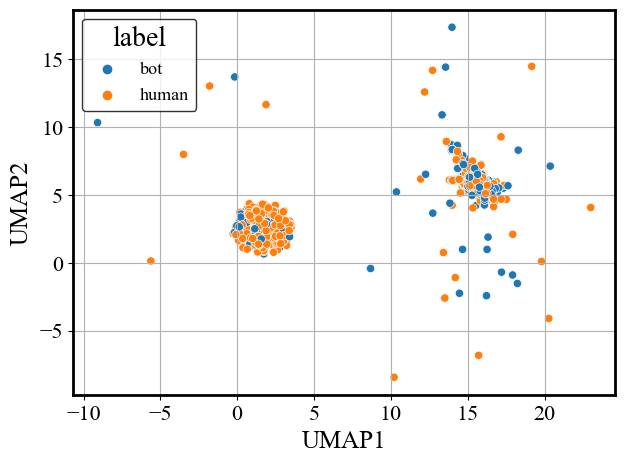

In [ ]:
# visualize the embedding
plt.figure(figsize=(7, 5))

sns.scatterplot(data=sample_df, x="UMAP1", y="UMAP2", hue = "label")
plt.show()

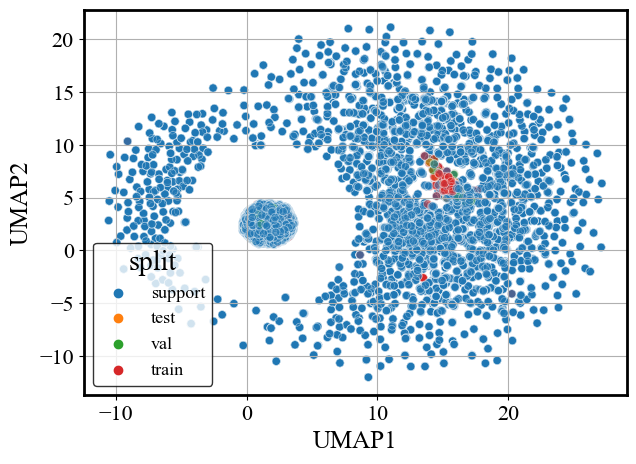

In [ ]:
# visualize the embedding
plt.figure(figsize=(7, 5))

sns.scatterplot(data=sample_df, x="UMAP1", y="UMAP2", hue = "split", alpha =0.5)
plt.show()

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

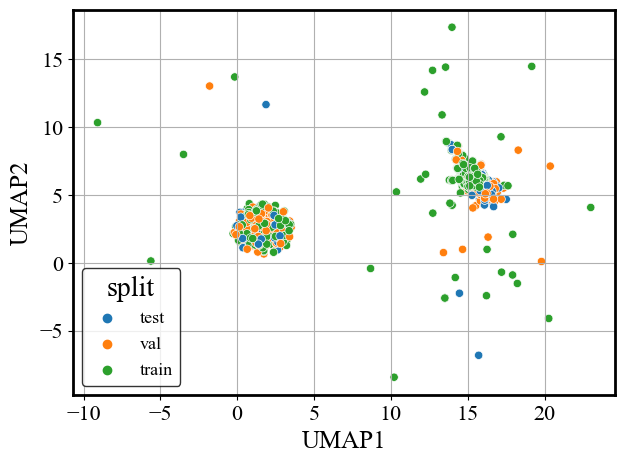

In [ ]:
# visualize the embedding
plt.figure(figsize=(7, 5))

sns.scatterplot(data=sample_df[lambda d: d.split != "support"], x="UMAP1", y="UMAP2", hue = "split")

# Feature Selection

In [ ]:
shap_values = model.predict(X_train, pred_contrib=True)
raw_preds = model.predict(X_train, raw_score=True)

shap_values_val = model.predict(X_val, pred_contrib=True)
raw_preds_val = model.predict(X_val, raw_score=True)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10


In [ ]:
score_without_feature = pd.DataFrame(raw_preds.reshape(-1,1) - shap_values)
score_without_feature_val = pd.DataFrame(raw_preds_val.reshape(-1,1) - shap_values_val)

In [ ]:
auc = roc_auc_score(preprocessed_profile_df[train_mask][target], raw_preds)

error_contrib = score_without_feature.apply(
    lambda d: roc_auc_score(preprocessed_profile_df[train_mask][target], d)
  ) - auc

auc = roc_auc_score(preprocessed_profile_df[val_mask][target], raw_preds_val)

error_contrib_val = score_without_feature_val.apply(lambda d: roc_auc_score(preprocessed_profile_df[val_mask][target], d)) - auc

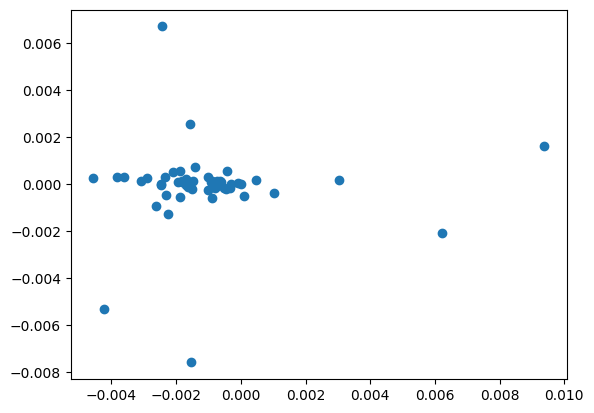

In [ ]:
plt.scatter(error_contrib, error_contrib_val)

## Code

In [ ]:
!pip install shap -q

In [ ]:
from toolz import curry

@curry
def fast_metric_with_ci_(data, *, n_samples=100, ci_level=0.95,
                     prediction='prediction', target='target', weight='weight', metric_fn = roc_auc_score):

    data = data.assign(weight=lambda df: df[weight] if weight is not None else 1)

    summary = (
        data
        .assign(
            prediction=lambda df: (1000 * df[prediction]).round(),
        )
        .groupby(["weight", 'prediction', target])
        .size().to_frame("sample_size")
        .reset_index()
    )

    estimate = (
        summary
        .assign(weight=lambda df: df["weight"] * df['sample_size'])
        .pipe(lambda df: metric_fn(df[target], df['prediction'], sample_weight=df['weight']))
    )

    bs_values = [
        summary
        .assign(weight=lambda df: df["weight"] * np.random.poisson(df['sample_size']))
        .pipe(lambda df: metric_fn(df[target], df['prediction'], sample_weight=df['weight']))
    for _ in range(n_samples)]

    lo, hi = bootstrap_ci(estimate, bs_values, ci_level=ci_level)

    return pd.Series(dict(
        estimate=estimate,
        ci_upper=hi,
        ci_lower=lo,
        model=prediction
    ))

@curry
def fast_auc_with_ci_sklearn(y_true, y_pred, *, sample_weight=None, n_samples=30, ci_level=0.95,):

    data = pd.DataFrame([y_true,y_pred], columns = ["target", "prediction"])
    if sample_weight is None:
      data["weight"] = 1
    else:
      data["weight"] = sample_weight

    return fast_auc_with_ci(data, n_samples=n_samples, ci_level=ci_level, prediction='prediction', target='defaulted', weight='weight', metric_fn = roc_auc_score)


def bootstrap_ci(sample_estimate, bootstrap_estimates, ci_level=0.95):
    lo = 2 * sample_estimate - np.quantile(bootstrap_estimates, (1 + ci_level) / 2)
    hi = 2 * sample_estimate - np.quantile(bootstrap_estimates, (1 - ci_level) / 2)
    return lo, hi



@curry
def fast_delta_metric_with_ci_(data, baseline, challenger, *, n_samples=100, ci_level=0.95,
                           target='target', weight='weight', metric_fn = roc_auc_score):

    data = data.assign(weight=lambda df: df[weight] if weight is not None else 1)

    summary = (
        data
        .assign(**{
            baseline: lambda df: (1000 * df[baseline]).round(),
            challenger: lambda df: (1000 * df[challenger]).round(),
        })
        .groupby(["weight", baseline, challenger, target])
        .size().to_frame("sample_size")
        .reset_index()
    )

    def delta_auc(df):
        challenger_auc = metric_fn(df[target], df[challenger], sample_weight=df['weight'])
        baseline_auc = metric_fn(df[target], df[baseline], sample_weight=df['weight'])
        return challenger_auc - baseline_auc

    estimate = (
        summary
        .assign(weight=lambda df: df["weight"] * df['sample_size'])
        .pipe(delta_auc)
    )

    bs_values = [
        summary
        .assign(weight=lambda df: df["weight"] * np.random.poisson(df['sample_size']))
        .pipe(delta_auc)
    for _ in range(n_samples)]

    lo, hi = bootstrap_ci(estimate, bs_values, ci_level=ci_level)

    return pd.Series(dict(
        estimate=estimate,
        ci_upper=hi,
        ci_lower=lo,
        model=challenger
    ))


@curry
def fast_delta_metric_with_ci(data, baseline, challengers, target, *, n_samples=100, ci_level=0.95, weight='weight', metric_fn = roc_auc_score):

    fn = fast_delta_metric_with_ci_(
        baseline=baseline,
        n_samples=n_samples,
        ci_level=ci_level,
        target=target,
        weight=weight,
        metric_fn=metric_fn
      )

    all_values = [fn(data=data,challenger=c) for c in challengers]

    return pd.DataFrame(all_values)

@curry
def fast_metric_with_ci(data, predictions, target, *, n_samples=100, ci_level=0.95, weight='weight', metric_fn = roc_auc_score):

    fn = fast_metric_with_ci_(
        target=target,
        n_samples=n_samples,
        ci_level=ci_level,
        weight=weight,
        metric_fn=metric_fn
      )

    all_values = [fn(data=data,prediction=p) for p in predictions]

    return pd.DataFrame(all_values)

In [ ]:
from sklearn.base import clone



def backwards_shap_feature_selection(
    model,
    df_train,
    df_val,
    candidate_features_for_removal,
    target,
    null_hypothesis = "all_features_are_good"
    fixed_features=[],
    extra_validation_sets = {},
    sample_weight=None,
    metric_fn = roc_auc_score,
    n_samples=20,
    ci_level=0.8,
    max_iter = 10,
    patience=0,
    max_removals_per_run=None
):

  """
  """
  #TODO: implement two null hypothesis strategies. currently only "all_features_are_good"


  #check key names
  valid_nulls = ["all_features_are_bad","all_features_are_good"]
  if not null_hypothesis in valid_nulls:
      raise(ValueError(f"null_hypothesis should be one of {valid_nulls}, got {null_hypothesis}"))

  keys_intersections = set(extra_validation_sets.keys()) & set(candidate_features_for_removal + fixed_features)
  if keys_intersections:
    raise ValueError(f"extra_validation_sets names should not match names of features. Found {keys_intersections}")

  keys_intersections = keys_intersections & set(["metric", "error-contribution"])
  if keys_intersections:
    raise ValueError(f"extra_validation_sets names or feature names should not be 'metric' or 'error-contribution'. Found {keys_intersections}")

  all_logs = []
  p=0
  for i in range(max_iter):

    #set all features
    all_features = candidate_features_for_removal + fixed_features

    if len(all_features) == 0:
      break

    run_logs = _backwards_shap_feature_selection(
        model=clone(model),
        df_train=df_train,
        df_val=df_val,
        all_features=all_features,
        extra_validation_sets=extra_validation_sets,
        target=target,
        sample_weight=sample_weight,
        metric_fn=metric_fn,
        n_samples=n_samples,
        ci_level=ci_level,
    )

    if null_hypothesis == "feature_is_good":
      features_to_remove = (
          run_logs
          [lambda d: d["ci_lower"] > 0]
          [lambda d: d["metric"] == "error-contribution"]
          [lambda d: ~d["model"].isin(fixed_features)]
          .sort_values(by = "ci_lower", ascending=False)
      )
    else:
      features_to_remove = (
          run_logs
          [lambda d: d["ci_upper"] > 0]
          [lambda d: d["metric"] == "error-contribution"]
          [lambda d: ~d["model"].isin(fixed_features)]
          .sort_values(by = "ci_upper", ascending=False)
      )


    if max_removals_per_run is not None:
      features_to_remove = features_to_remove.iloc[:max_removals_per_run]

    features_to_remove = features_to_remove["model"].values.tolist() #model means the model without the feature

    run_logs["run_index"] = i
    run_logs["n_features"] = (run_logs["metric"] == "error-contribution").sum()
    run_logs["removed_features"] = str(features_to_remove)
    run_logs["n_features_removed"] = len(features_to_remove)
    all_logs.append(run_logs)

    if len(features_to_remove) == 0:
      if patience:
        if p >= patience:
          break
        else:
          p+=1
      else:
        break
    #update features for the next iteration
    candidate_features_for_removal = [i for i in candidate_features_for_removal if not i in features_to_remove]
    i+=1

  return pd.concat(all_logs, ignore_index=True)


def _backwards_shap_feature_selection(
    model,
    df_train,
    df_val,
    all_features,
    extra_validation_sets,
    target,
    sample_weight,
    metric_fn,
    n_samples,
    ci_level,
):

  #train model
  model.fit(
      df_train[all_features],
      df_train[target],
      sample_weight=sample_weight
  )


  #calculate shap
  explainer = shap.TreeExplainer(model)
  shap_values_val = explainer.shap_values(df_val[all_features])[-1]

  #make raw preds
  raw_preds_val = proba_to_log_odds(model.predict_proba(df_val[all_features])[:,-1])

  #score without feature
  scores_df = pd.DataFrame(
      log_odds_to_proba(raw_preds_val.reshape(-1,1) - shap_values_val),
      columns = all_features
  )

  #add extra columns
  scores_df["val_set"] = raw_preds_val
  scores_df[target] = df_val[target].values
  if sample_weight is not None:
    df_val[sample_weight].values


  #deltas
  error_contributions_with_ci = fast_delta_metric_with_ci(
      scores_df,
      baseline="val_set",
      challengers=all_features,
      n_samples=n_samples,
      ci_level=ci_level,
      target=target,
      weight=sample_weight,
      metric_fn = metric_fn
    ).assign(metric="error-contribution")

  #current setup auc
  metric = fast_metric_with_ci(
      scores_df,
      predictions=["val_set"],
      n_samples=n_samples,
      ci_level=ci_level,
      target=target,
      weight=sample_weight,
      metric_fn = metric_fn
    ).assign(metric="metric", used_features=str(all_fatures))

  extra_val_logs = []
  for k,d in extra_validation_sets.items():
    extra_val_logs.append(
        fast_metric_with_ci(
          d.assign(**{k:lambda d: model.predict_proba(d[all_features])[:,-1], "weight__":lambda d: d[sample_weight] if sample_weight is not None else 1}),
          predictions=[k],
          n_samples=n_samples,
          ci_level=ci_level,
          target=target,
          weight="weight__",
          metric_fn = metric_fn
      ).assign(metric="metric", used_features=str(all_fatures))
    )



  return pd.concat([error_contributions_with_ci,metric], ignore_index = True)

## Run feature selection

In [ ]:

fs_logs = backwards_shap_feature_selection(
    RandomForestClassifier(n_jobs = -1, min_samples_leaf = 5),
    df[train_mask],
    df[val_mask],
    candidate_features_for_removal = embs_names,
    target=target,
    fixed_features=[],
    sample_weight=None,
    metric_fn = roc_auc_score,
    n_samples=10,
    ci_level=0.60,
    max_iter=10,
    max_removals_per_run=None
)

[LightGBM] [Info] Number of positive: 2916, number of negative: 3665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.319811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 793833
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 3122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443094 -> initscore=-0.228616
[LightGBM] [Info] Start training from score -0.228616


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


KeyboardInterrupt: ignored

In [ ]:
fs_logs[lambda d: d.model == "baseline_prediction"]

<Axes: xlabel='ci_lower', ylabel='Count'>

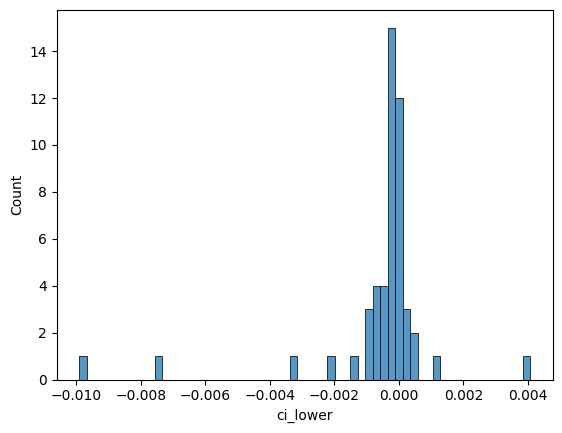

In [ ]:
import seaborn as sns
df_.pipe(sns.histplot, x="ci_lower")